In [1]:
import psycopg2
import numpy
import pandas as pd
import matplotlib.pyplot as plt

## Apertura de la base de datos

In [57]:
conn = psycopg2.connect(database="centrotic", user="postgres",
                      password="raspberry", host="127.0.0.1",
                      port="5432")

In [70]:
cur = conn.cursor()
cur.execute("SELECT nfft, espectro, frec_central, frec_muestreo FROM radioastronomia_espectro WHERE (frec_central = 96000000 AND nfft=1024)")
rows = cur.fetchall()


In [71]:
nfft = rows[0][0]
espectro = rows[0][1]
frec_central = rows[0][2]
frec_muestreo = rows[0][3]

1024


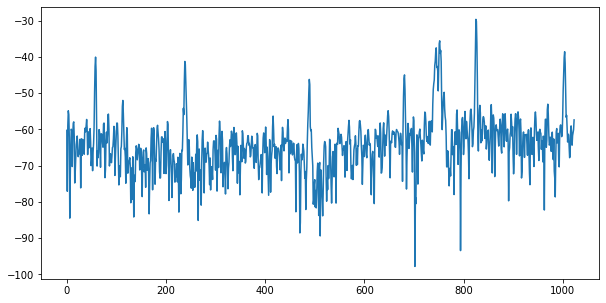

In [74]:
plt.figure(figsize=(10,5))
plt.plot(espectro[0:nfft])
print(nfft)

In [75]:
s = espectro[0:nfft*1]
for i in range(int(len(espectro)/nfft)-1):
    s = numpy.vstack((s, espectro[nfft*(i+1):nfft*(i+2)]))

In [76]:
dfs = pd.DataFrame(data=s)

In [77]:
dfs = dfs.transpose()
dfs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1024 entries, 0 to 1023
Columns: 782 entries, 0 to 781
dtypes: float64(782)
memory usage: 6.1 MB


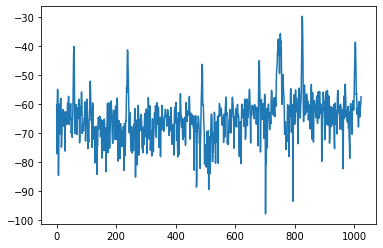

In [78]:
plt.plot(dfs[0])

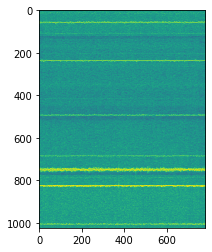

In [79]:

plt.imshow(dfs)

## querys para extraer barrido

seleccion de las frecuencias de muestreo, las frecuencias centrales
y el tamaño de la FFT, esto es para que el espectro seleccionado tenga las 
mismas características


In [134]:
cur.execute("SELECT DISTINCT frec_central FROM radioastronomia_espectro ORDER BY frec_central;")
rows = cur.fetchall()
frec_central = []
for row in rows:
    frec_central.append(row[0])

cur.execute("SELECT DISTINCT frec_muestreo FROM radioastronomia_espectro;")
rows = cur.fetchall()
frec_muestreo = []
for row in rows:
    print(row)
    frec_muestreo.append(row[0])

cur.execute("SELECT DISTINCT nfft FROM radioastronomia_espectro;")
rows = cur.fetchall()
nfft = []
for row in rows:
    nfft.append(row[0])

print("frecuencia muestreo {}".format(frec_muestreo))
print("frecuencia central {}".format(frec_central))
print("tamano FFT {}".format(nfft))

(16000000,)
frecuencia muestreo [16000000]
frecuencia central [78000000.0, 86000000.0, 94000000.0, 102000000.0, 110000000.0, 118000000.0, 126000000.0, 134000000.0, 142000000.0, 150000000.0, 158000000.0, 166000000.0, 174000000.0, 182000000.0, 190000000.0, 198000000.0, 206000000.0, 214000000.0, 222000000.0, 230000000.0, 238000000.0, 246000000.0]
tamano FFT [1024]


## seleccion de los tamaños de FFT

# Este es el generador de querys principal para crear el reporte

In [136]:
""" Esto hace un barrido de frecuencias """
for frec_cen in frec_central:
    for frec_mue in frec_muestreo:
        for fft in nfft:
            query = []
            query.append("SELECT espectro FROM radioastronomia_espectro ")
            query.append("WHERE (nfft = ")
            query.append(str(fft))
            query.append(" AND frec_muestreo = ")
            query.append(str(frec_mue))
            query.append(" AND frec_central = ")
            query.append(str(frec_cen))
            query.append(");")
            query = "".join(query)
            print(query)
            
            # extraccion del espectro
            cur.execute(query)
            rows = cur.fetchall()
            for row in rows:
                espectro = row[0]
                espectro = numpy.asarray(espectro)
                K = int(len(espectro)/(fft))
                x = numpy.zeros(fft)
                for i in range(K):
                    x = x + espectro[i*fft:(i+1)*fft]
                x = x/K

SELECT espectro FROM radioastronomia_espectro WHERE (nfft = 1024 AND frec_muestreo = 16000000 AND frec_central = 78000000.0);
SELECT espectro FROM radioastronomia_espectro WHERE (nfft = 1024 AND frec_muestreo = 16000000 AND frec_central = 86000000.0);
SELECT espectro FROM radioastronomia_espectro WHERE (nfft = 1024 AND frec_muestreo = 16000000 AND frec_central = 94000000.0);
SELECT espectro FROM radioastronomia_espectro WHERE (nfft = 1024 AND frec_muestreo = 16000000 AND frec_central = 102000000.0);
SELECT espectro FROM radioastronomia_espectro WHERE (nfft = 1024 AND frec_muestreo = 16000000 AND frec_central = 110000000.0);
SELECT espectro FROM radioastronomia_espectro WHERE (nfft = 1024 AND frec_muestreo = 16000000 AND frec_central = 118000000.0);
SELECT espectro FROM radioastronomia_espectro WHERE (nfft = 1024 AND frec_muestreo = 16000000 AND frec_central = 126000000.0);
SELECT espectro FROM radioastronomia_espectro WHERE (nfft = 1024 AND frec_muestreo = 16000000 AND frec_central = 1

# prueba de espectros

In [144]:
cur.execute("SELECT espectro FROM radioastronomia_espectro WHERE (nfft = 1024 AND frec_muestreo = 16000000 AND frec_central = 86000000.0);")
rows = cur.fetchall()

In [151]:
espectro = rows[0][0]
espectro = numpy.asarray(espectro)
K = int(len(espectro)/(1024))
x = numpy.zeros(1024)
for i in range(K):
    x = x + espectro[i*1024:(i+1)*1024]
x = x/K


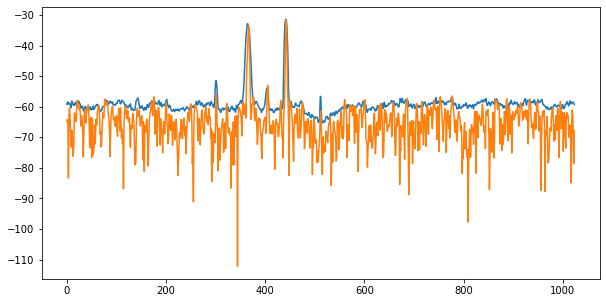

In [152]:
plt.figure(figsize=(10,5))
plt.plot(x[0:1024])
plt.plot(espectro[0:1024])

In [153]:
conn.close()